In [1]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                            QuadraticDiscriminantAnalysis)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier

## Cargamos dataset

In [2]:
# Cargamos dataset Iris
ds = pd.read_csv('iris.data', header=None, names=['largo_sepalo',
                                                  'ancho_sepalo',
                                                  'largo_petalo',
                                                  'ancho_petalo',
                                                  'clase'])

In [3]:
output = 'clase'
y = ds[output].values
X = ds.drop(output,axis=1).values

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Dado que no los hay, seguimos adelante.

In [4]:
attr = []
# Iteramos los atributos del dataset
for i in ds.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(ds[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [5]:
ds.columns.drop(output)[ds.std() < 0.001]

Index([], dtype='object')

**Comprobamos que no haya variables iguales**  
Vemos que no hay ninguna.

In [6]:
resultados = np.zeros((len(ds.columns), len(ds.columns)))
for i in range(len(ds.columns)):
    for j in range(len(ds.columns)):
        resultados[i, j] = np.mean(ds.iloc[:, i] == ds.iloc[:, j])

In [7]:
iguales = []
for i, j in it.combinations(range(len(ds.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(ds.columns[i])
        print(ds.columns[i], ds.columns[j])

**Comprobamos que las clases no estén desbalanceadas**  
No lo están.

In [8]:
y = np.array([i for i,j in enumerate(set(y)) for k in y if j == k])

In [9]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))
print('Proporción clase 2: ',np.mean(y==2))

Proporción clase 0:  0.3333333333333333
Proporción clase 1:  0.3333333333333333
Proporción clase 2:  0.3333333333333333


**Desordenamos los datos**

In [10]:
X,y = shuffle(X,y)

## Detección de Outliers
Visualizamos de distintas formas los posibles outliers  
y vemos que se puede considerar que existen pero son pocos y no los tratamos.

In [11]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [12]:
y_pred = clf.fit_predict(X)

In [13]:
X_scores = clf.negative_outlier_factor_

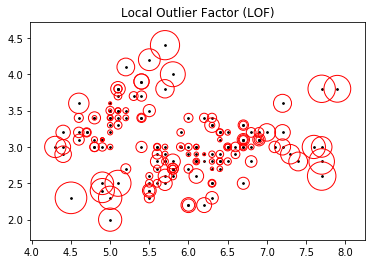

In [14]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.show()

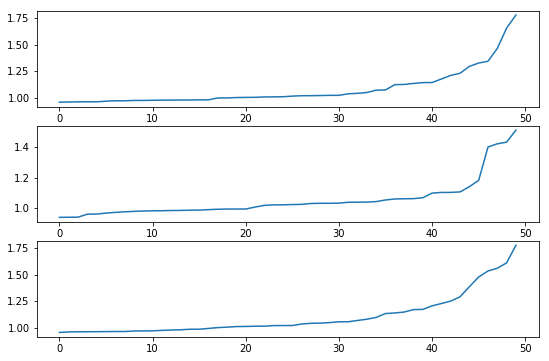

In [15]:
f, ax = plt.subplots(3,1,figsize=(9,6))
for i in set(y):
    temp = X[y == i]
    y_pred = clf.fit_predict(temp)
    temp_scores = clf.negative_outlier_factor_
    ax[i].plot(range(len(temp_scores)),sorted(-temp_scores))

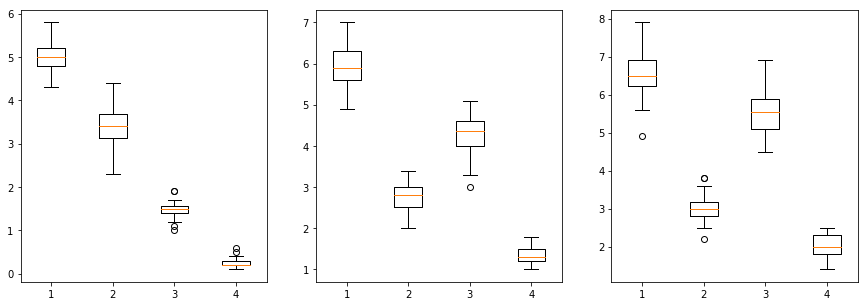

In [16]:
f, ax = plt.subplots(1,3,figsize=(15,5))
for i in set(y):
    temp = X[y == i]
    data = []
    for j in range(X.shape[1]):
        data.append(temp[:,j])
    bp = ax[i].boxplot(data)
plt.show()

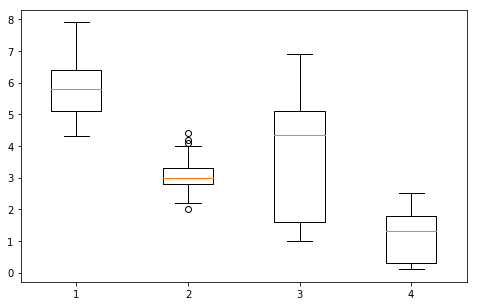

In [17]:
# Create a figure instance
fig = plt.figure(figsize=(8, 5))
# Create an axes instance
ax = fig.add_subplot(111)
data = []
for j in range(X.shape[1]):
    data.append(X[:,j])
bp = ax.boxplot(data)
plt.show()

## Entrenamiento de Modelos

**kFold - Linear Discriminant Analysis**

In [18]:
kf = KFold(n_splits=10)
resultados_train = []
resultados_test = []
for tipo in ('lsqr', 'eigen', 'svd'):
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
            alg.fit(X_train, y_train)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_test.append(alg.score(X_test, y_test))
resultados_train = np.reshape(resultados_train,(30,3),order='F')
resultados_test = np.reshape(resultados_test,(30,3),order='F')

**Test de normalidad**  
Rechazamos normalidad

In [19]:
print(stats.shapiro(resultados_test[:,0])[1])
print(stats.shapiro(resultados_test[:,1])[1])
print(stats.shapiro(resultados_test[:,2])[1])

6.841545108215996e-09
1.8855885173252318e-06
6.841545108215996e-09


**Test de Kruskal-Wallis**  
No se puede rechazar que las precisiones sean similares

In [20]:
print(stats.kruskal(resultados_test[:,0],
                    resultados_test[:,1],
                    resultados_test[:,2]))

KruskalResult(statistic=3.2040000000000193, pvalue=0.20149312848263937)


**kFold - Quadratic Discriminant Analysis**

In [21]:
kf = KFold(n_splits=10)
resultados_trainq = []
resultados_testq = []
for _ in range(3):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        alg = QuadraticDiscriminantAnalysis(priors=np.array([1/3, 1/3, 1/3]))
        alg.fit(X_train, y_train)
        resultados_trainq.append(alg.score(X_train, y_train))
        resultados_testq.append(alg.score(X_test, y_test))

**Test de normalidad**  
Rechazamos normalidad

In [22]:
print(stats.shapiro(resultados_testq)[1])

1.5443491463429382e-07


**Test de Kruskal-Wallis**  
No se puede rechazar que las precisiones sean similares

In [23]:
print(stats.kruskal(resultados_test[:,0],
                    resultados_test[:,1],
                    resultados_test[:,2],
                    resultados_testq))

KruskalResult(statistic=3.245454545454563, pvalue=0.3553067916022005)


**Nos quedamos con el más sencillo**  
El cual asumimos que es el Lineal Discriminant Analysis con lsqr (mínimos cuadrados)

In [24]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real == PositiveClass and predicted != PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
alg = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None)
alg.fit(X_train, y_train)
y_pred = alg.predict(X_test)
CM = confusion_matrix(y_test, y_pred)
Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
print(('Sens: {:.2f}, Spec: {:.2f}, ' +
      'PPV: {:.2f}, NPV: {:.2f}, ACC: {:.2f}').format(Sens,Spec,PPV,NPV,ACC))

Sens: 0.86, Spec: 1.00, PPV: 1.00, NPV: 0.92, ACC: 0.95


**----------------------------------------------------------------------------------------------------------------------------**

**kFold - Decision Tree Classifier**

In [40]:
kf = KFold(n_splits=10)
resultados_traind = []
resultados_testd = []
resultados_validd = []
# Cambiar este for _ para probar distintas configuraciones del DecisionTree

for _ in range(3):
    for train_index, test_index in kf.split(X):
#         train_test_split del conjunto train y pillar 1/9 para validación
        X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
        X_test, y_test = X[test_index], y[test_index]
#         print('X_train: {}\n, X_valid: {}\n, X_test: {}'.format(X_train, X_valid, X_test))
        alg = DecisionTreeClassifier()
        alg.fit(X_train, y_train)
        resultados_traind.append(alg.score(X_train, y_train))
        resultados_validd.append(alg.score(X_valid, y_valid))
#         resultados_testd.append(alg.score(X_test, y_test))

**TODO:**
Entrenar varias versiones (mínimo 5) variando:
- max_depth [3,5,7] (default=None)
- min_samples_leaf (default=1)
- min_samples_split (default=2)
Usar 8/10 train 1/10 validation 1/10 test
- min_impurity_decrease (default=0.): calcula los niveles necesarios hasta que la impurezca deje de mejorar
lo ideal sería controlar el nivel de impureza en tiempo de entrenamiento.
En principio presentamos a las 16:45

## Persistencia

In [ ]:
# with open('RForest_Zika_oversampled.bin','wb') as file:
#     pickle.dump(alg_o, file)
# with open('RForest_Zika_undersampled.bin','wb') as file:
#     pickle.dump(alg_u, file)

## FIN